In [2]:
import importlib
import sys
from vae_model import VAE
from hdf_dataset import HDFDataset
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import torch
import torch.utils.data as data_utils
import pickle

# Preprocessing
We normalize the features, shuffle it and create a training-test split. In addition I check the effect of second order polynomial features.

In [3]:
POLY_DEG = 1
df = pd.read_hdf("events_anomalydetection_v2.features.h5")
y = df["label"]
X = df.loc[:, df.columns != "label"]
#mean = X.mean()
#std = X.std()
#X = (X - mean)/std
poly = PolynomialFeatures(POLY_DEG)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X.describe()

,1,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
count,1100000.0,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,1.0,-1.327996e+00,2.602047e+00,1.200619e-01,2.195990e+02,1.363843e+02,5.571819e+01,3.742071e+01,1.132151e+00,-2.496534e+00,-8.540738e-01,2.089902e+02,1.290355e+02,5.338557e+01,3.605997e+01
std,0.0,1.001400e+03,1.001730e+03,1.153441e+03,1.647181e+02,1.382575e+02,4.940572e+01,2.998556e+01,8.847728e+02,8.851543e+02,1.163099e+03,1.527055e+02,1.286603e+02,4.670867e+01,2.837653e+01
min,1.0,-3.880100e+03,-3.320690e+03,-5.587720e+03,-2.642900e-05,0.000000e+00,0.000000e+00,0.000000e+00,-3.740480e+03,-3.406180e+03,-5.490730e+03,-3.411970e-05,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.0,-9.695655e+02,-9.663385e+02,-7.231380e+02,9.768073e+01,4.287708e+01,2.281695e+01,1.619798e+01,-7.972635e+02,-8.014985e+02,-7.380858e+02,9.543755e+01,4.065460e+01,2.221150e+01,1.605428e+01
50%,1.0,-1.785130e+00,5.091580e+00,1.598670e+00,1.629155e+02,8.372715e+01,4.143035e+01,2.934835e+01,2.593420e+00,-5.038455e+00,2.205830e-01,1.597260e+02,8.109740e+01,3.981480e+01,2.856560e+01
75%,1.0,9.659120e+02,9.702918e+02,7.237895e+02,2.998730e+02,1.776495e+02,7.149420e+01,4.973332e+01,8.002305e+02,7.979622e+02,7.365130e+02,2.836275e+02,1.699862e+02,6.866177e+01,4.770973e+01
max,1.0,3.852430e+03,3.484770e+03,6.155580e+03,1.615690e+03,1.473960e+03,7.564940e+02,4.504640e+02,3.630150e+03,3.295420e+03,5.620940e+03,1.508690e+03,1.464820e+03,7.450410e+02,4.914610e+02


## Visualization
Below I present histograms for all of the features.
Polynomial features seem to improve signal-bg separation.

array([[<AxesSubplot:title={'center':'mj1'}>,
        <AxesSubplot:title={'center':'mj2'}>],
       [<AxesSubplot:title={'center':'tau1j1'}>,
        <AxesSubplot:title={'center':'tau1j2'}>]], dtype=object)

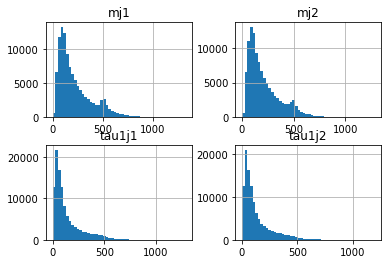

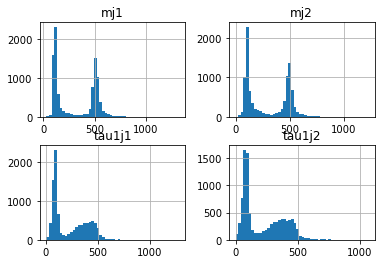

In [52]:
X_test.hist(column=['mj1', 'mj2', 'tau1j1', 'tau1j2'], bins=50)
X_test[y_test == 1].hist(column=['mj1', 'mj2', 'tau1j1', 'tau1j2'], bins=50)

Plots of all variables

In [ ]:
for column in X_test.columns:
    X_test.hist(column=column, bins=50)
    X_test[y_test == 1].hist(column=column, bins=50)

Correlation with label, a high absolute value means the feature is a good indicator of signal.
We see the polynomial features sometimes exceed the non-polynomial ones.

<AxesSubplot:>

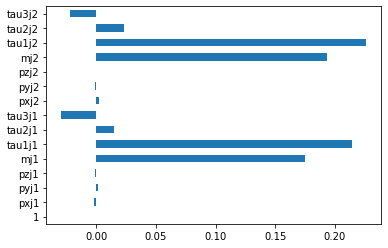

In [53]:
X_train.corrwith(y_train).plot(kind='barh')

## PCA and further analysis
We see $\tau_{j_1}, \tau_{j_2}, m_{j_1}, m_{j_2}$ contains the most variance followed by $\vec{p}_{j_1}, \vec{p}_{j_2}$

             PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
1      -0.000000  0.000000  0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
pxj1    0.289583 -0.691997 -0.014328 -0.000795 -0.000437  0.000073 -0.641751   
pyj1    0.692125  0.289517  0.000063 -0.003423 -0.000178 -0.000088  0.158979   
pzj1   -0.001732  0.012812 -0.685228  0.728214  0.000193 -0.000162 -0.000179   
mj1     0.000153  0.000134  0.000099 -0.000063  0.732616  0.170618 -0.000786   
tau1j1  0.000146  0.000055  0.000078 -0.000061  0.607740  0.148813 -0.000182   
tau2j1 -0.000012 -0.000015  0.000009 -0.000019  0.173732  0.043608  0.000267   
tau3j1 -0.000002  0.000007  0.000003 -0.000011  0.100120  0.023910  0.000106   
pxj2   -0.255036  0.609812  0.012692  0.000408 -0.000582  0.000137 -0.728282   
pyj2   -0.609907 -0.255216 -0.000008  0.002993  0.000042  0.000440  0.180241   
pzj2    0.008448 -0.012218  0.728077  0.685334 -0.000016 -0.000060 -0.000114   
mj2     0.000244  0.000027 -0.000084  0.

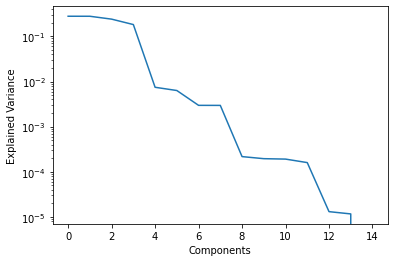

In [54]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(X.columns))],
index=X.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Rotating into the PCs we see the PCs that differentiate well between signal and background: 1, 6, 8, 10, 11

/Users/rotem/opt/anaconda3/envs/NAF/lib/python2.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rotem/opt/anaconda3/envs/NAF/lib/python2.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


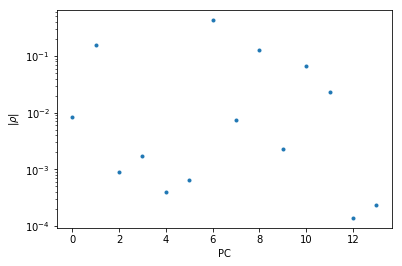

In [11]:
X_pca = pca.transform(X)
plt.plot(np.linspace(0, X.shape[1]-1, X.shape[1]), np.abs(np.corrcoef(X_pca.T, y)[:-1, -1]), '.')
plt.xlabel("PC")
plt.ylabel(r"$|\rho|$")
plt.yscale('log')

## Linear classifier test
To assess the quality of the features we use we can check how well a linear classifier fits the label of the training set to them.

Some simple NNs and decision trees are tested for reference.

When successful, this means that the non-linearity differentiating between the signal and background is captured by the features.

In [16]:
models = {"Linear_1e-5": linear_model.SGDClassifier(alpha=1e-5)}
#          "BDT_1_100":  AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100),
#          "MLP_10_10": MLPClassifier(hidden_layer_sizes=(10, 10)),
#          "MLP_5_5": MLPClassifier(hidden_layer_sizes=(5, 5))}

for name in models:
    models[name].fit(X_train, y_train)

A ROC curve is used to evaluate the effectiveness of the classification.

Linear_1e-5: 0.0864454545455


Text(0,0.5,'TPR')

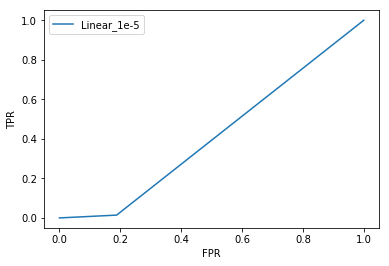

In [18]:
for name in models:
    model = models[name]
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    print(f"{name}: {mse}")
    tpr, fpr, thresh = metrics.roc_curve(y_test, model.predict(X_test))
    plt.plot(fpr, tpr, label=name)
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

# VAE
Now lets give it a go using a $\beta$-VAE.

In [21]:
importlib.reload(sys.modules['vae_model'])
importlib.reload(sys.modules['hdf_dataset'])
from vae_model import VAE
from hdf_dataset import HDFDataset

EPOCHS = 1
BATCH_SIZE = 128
BETA = 0.5
LATENT_SPACE_DIM = 1
LR = 1e-6
dataset = HDFDataset("events_anomalydetection_v2.features.h5")

model = VAE(latent_dim=LATENT_SPACE_DIM, input_dim=dataset.num_features(), beta=BETA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

dataloader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
losses = model.train(dataloader=dataloader, optimizer=optimizer, epochs=EPOCHS)

  0%|          | 0/8594 [00:00<?, ?it/s]/Users/rotem/opt/anaconda3/envs/NAF/lib/python2.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/1 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'isinf'

In [40]:
losses[-1]

409332704.0

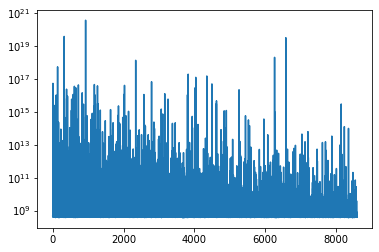

In [42]:
plt.plot(losses)
plt.yscale('log')

## Creating bins and datasets
We create the different bins from the data for training purposes, $m_{jj}$ is chosen as the discriminatory variable

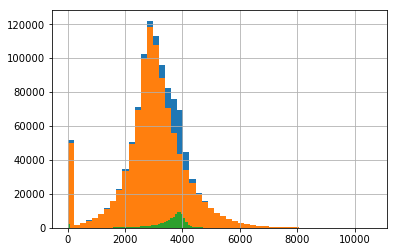

In [4]:
def get_mjj(df):
    e1sq = df['pxj1']**2 + df['pyj1']**2 + df['pzj1']**2 + df['mj1']**2
    e2sq = df['pxj2']**2 + df['pyj2']**2 + df['pzj2']**2 + df['mj2']**2
    ptotsq = (df['pxj1'] + df['pxj2'])**2 + (df['pyj1'] + df['pyj2'])**2 + (df['pzj1'] + df['pzj2'])**2
    mjjsq = e1sq + e2sq - ptotsq
    mjjsq[mjjsq < 0] = 0
    return mjjsq**0.5

signal = df['label'] == 1
mjj = get_mjj(df)
mjj = mjj / mjj[signal].mean() * 3500 # seems not to match the expected value for some reason so I fixed it
mjj.hist(bins=50)
mjj[df['label'] == 0].hist(bins=50)
mjj[signal].hist(bins=100)

In [7]:
q=10
df["mjj_bins"] = pd.qcut(mjj, q=q, precision=100)
df["mjj_bin_num"] = pd.qcut(mjj, q=q, labels=[i for i in range(1, q+1)])
df["mjj_bins"].unique()
# important bins are 6 to 9

[(3533.57276669, 3838.87087541], (3049.41386997, 3269.1459151], (3269.1459151, 3533.57276669], (1775.20493395, 2366.80126755], (4262.42752501, 10605.6093931], (2366.80126755, 2655.74295419], (2655.74295419, 2855.56913405], (3838.87087541, 4262.42752501], (-1e-100, 1775.20493395], (2855.56913405, 3049.41386997]]
Categories (10, interval[float64]): [(-1e-100, 1775.20493395] < (1775.20493395, 2366.80126755] < (2366.80126755, 2655.74295419] < (2655.74295419, 2855.56913405] ... (3269.1459151, 3533.57276669] < (3533.57276669, 3838.87087541] < (3838.87087541, 4262.42752501] < (4262.42752501, 10605.6093931]]

In [6]:
# Need to make sure it is done with python 2.7 for unpickle to work
for i in range(int(q/2), q+1):
    x = df[df["mjj_bin_num"] == i].to_numpy()[:,:-3]
    np.save("../NAF/external_maf/datasets/data/lhc/lhc_mjj_bin_{}of{}.npy".format(i,q), x, allow_pickle=True)

For sanity plotting the jet mass difference

<AxesSubplot:>

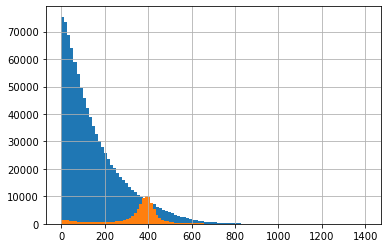

In [48]:
fig, ax = plt.subplots()
np.abs(df['mj1']-df['mj2'])[~signal].hist(bins=100)
np.abs(df['mj1']-df['mj2'])[signal].hist(bins=100)